In [1]:
from typing import List, Dict
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt

from datatypes import Trip, TripInfo, TaxiSimulationLog
from utilities import retrieve

In [2]:
trips: List[Trip] = retrieve('../temp/trips.pkl')
trip_ids = [str(trip.id) for trip in trips]

In [3]:
# Retrive data for base simulation

base_info_tree = ET.parse('../temp/base.tripinfo.xml')
base_info_root = base_info_tree.getroot()
base_trip_infos: List[TripInfo] = {}

for trip_info in base_info_root.findall('tripinfo'):
    base_trip_infos[trip_info.attrib['id']] = TripInfo(
        trip_info.attrib['id'],
        '',
        0.0,
        float(trip_info.attrib['duration']),
        float(trip_info.attrib['routeLength'])
    )

In [4]:
# Retrive data for taxi simulation

taxi_info_tree = ET.parse('../temp/taxi.tripinfo.xml')
taxi_info_root = taxi_info_tree.getroot()
taxi_trip_infos: Dict[str, TripInfo] = {}
taxi_simulation_logs: List[TaxiSimulationLog] = retrieve('../temp/taxi_simulation_log.pkl')

for trip_info in taxi_info_root.findall('personinfo'):
    ride_info = trip_info[0]
    taxi_trip_infos[trip_info.attrib['id']] = TripInfo(
        trip_info.attrib['id'],
        ride_info.attrib['vehicle'],
        float(ride_info.attrib['waitingTime']),
        float(ride_info.attrib['duration']),
        float(ride_info.attrib['routeLength'])
    )

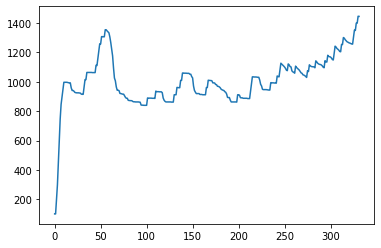

In [5]:
# Show number of taxis in fleet over time

plt.plot([log.taxi_count for log in taxi_simulation_logs])
plt.show()

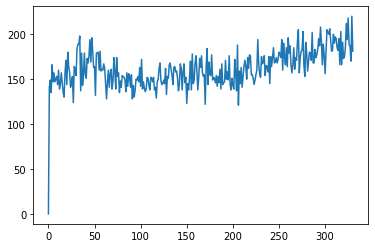

In [6]:
# Show number of new reservations over time

reservation_counts = []
for i in range(1, len(taxi_simulation_logs)):
    reservation_counts.append(
        taxi_simulation_logs[i].reservation_count - taxi_simulation_logs[i-1].reservation_count
    )
    
plt.plot(reservation_counts)
plt.show()

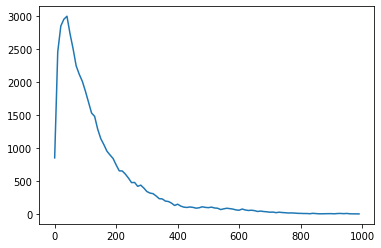

In [19]:
# Show waiting times

x = [i*10 for i in range(100)]
y = [0 for i in range(100)]

for trip_id, trip_info in taxi_trip_infos.items():
    waiting_time = trip_info.waiting_time
    for i in range(len(y)):
        if (10*i < waiting_time < 10*(i+1)):
            y[i] += 1

plt.plot(x, y)
plt.show()

In [8]:
# Process and compare data

base_travel_times = []
taxi_travel_times = []
for trip_id in trip_ids:
    if (trip_id in base_trip_infos and trip_id in taxi_trip_infos):
        base_travel_times.append(base_trip_infos[trip_id].duration)
        taxi_travel_times.append(taxi_trip_infos[trip_id].duration)

print('test: {}, {}'.format(len(base_travel_times), len(taxi_travel_times)))
print('base travel time: {}, taxi travel time: {}'.format(sum(base_travel_times), sum(taxi_travel_times)))
print('taxi travel times is {}% more that the the duration of base travel times'.format(sum(taxi_travel_times)/sum(base_travel_times)*100))


test: 52113, 52113
base travel time: 28400209.0, taxi travel time: 29454899.0
taxi travel times is 103.71366985362678% more that the the duration of base travel times
